In [1]:
%pip install anomalib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 14.9 MB/s 
     |████████████████████████████████| 11.2 MB 91.7 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 705 kB 87.0 MB/s 
     |████████████████████████████████| 21.0 MB 70.9 MB/s 
     |████████████████████████████████| 6.1 MB 90.4 MB/s 
     |████████████████████████████████| 1.8 MB 85.7 MB/s 
     |████████████████████████████████| 431 kB 77.1 MB/s 
     |████████████████████████████████| 419 kB 94.2 MB/s 
     |████████████████████████████████| 517 kB 99.6 MB/s 
     |████████████████████████████████| 10.4 MB 86.4 MB/s 
     |████████████████████████████████| 154 kB 92.2 MB/s 
     |████████████████████████████████| 157 kB 67.8 MB/s 
     |████████████████████████████████| 181 kB 72.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |██████████████████████████

In [2]:
from functools import partial, update_wrapper
from types import MethodType
from typing import Any

from pathlib import Path
from IPython.display import display
from PIL import Image

from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader

from anomalib.data import InferenceDataset
from anomalib.data.folder import Folder
from anomalib.models.fastflow.lightning_model import Fastflow
from anomalib.post_processing import superimpose_anomaly_map
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import (
    ImageVisualizerCallback,
    MetricsConfigurationCallback,
    MetricVisualizerCallback,
    MinMaxNormalizationCallback,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/cli.py:95: LightningDeprecationWarning: `LightningCLI`'s registries were deprecated in v1.7 and will be removed in v1.9. Now any imported subclass is automatically available by name in `LightningCLI` without any need to explicitly register it.
  rank_zero_deprecation(_deprecate_registry_message)


# Data Module

In [3]:
folder_datamodule = Folder(
    root="/content/drive/MyDrive/anomaly_detection/datasets/01-4_EP_renew-battery",
    normal_dir="03_normal",
    abnormal_dir="04_abnormal",
    task="segmentation",
    mask_dir="/content/drive/MyDrive/anomaly_detection/datasets/01-4_EP_renew-battery/05_mask",
    seed = 1024,
    image_size=256,
)
folder_datamodule.setup()

In [4]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
data.keys(), data["image"].shape

(dict_keys(['image']), torch.Size([32, 3, 256, 256]))

In [5]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
data.keys(), data["image"].shape, data["mask"].shape

(dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask']),
 torch.Size([32, 3, 256, 256]),
 torch.Size([32, 256, 256]))

# Model : FastFlow

In [9]:
model = Fastflow(input_size=[256, 256], backbone="wide_resnet50_2", flow_steps=8)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (AdaptiveThreshold). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictio

In [10]:
model.training = True
train_output = model(data["image"])
hidden_variables, log_jacobian = train_output
print(f"Hidden Variable Shape: {hidden_variables[0].shape}")

Hidden Variable Shape: torch.Size([32, 256, 64, 64])


In [11]:
model.model.training = False
anomaly_map = model(data["image"])
print(f"Anomaly Map Shape: {anomaly_map.shape}")

Anomaly Map Shape: torch.Size([32, 1, 256, 256])


## Training

### Optimizer

In [12]:
def configure_optimizers(lightning_module: LightningModule, optimizer: Optimizer) -> Any:  # pylint: disable=W0613,W0621
    """Override to customize the LightningModule.configure_optimizers` method."""
    return optimizer


optimizer = Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)
fn = partial(configure_optimizers, optimizer=optimizer)
update_wrapper(fn, configure_optimizers)  # necessary for `is_overridden`
model.configure_optimizers = MethodType(fn, model)

### Callbacks

In [13]:
callbacks = [
    MetricsConfigurationCallback(
        adaptive_threshold=True,
        image_metric_names=["AUROC"],
        pixel_metric_names=["AUROC"],
    ),
    ModelCheckpoint(
        mode="max",
        monitor="pixel_AUROC",
    ),
    EarlyStopping(
        monitor="pixel_AUROC",
        mode="max",
        patience=3,
    ),
    MinMaxNormalizationCallback(),
    ImageVisualizerCallback(mode="full", task="segmentation", image_save_path="/content/drive/MyDrive/anomaly_detection/anomalib/results/images"),
    MetricVisualizerCallback(mode="full", task="segmentation", image_save_path="/content/drive/MyDrive/anomaly_detection/anomalib/results/images"),
]

In [14]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    max_epochs=100,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(datamodule=folder_datamodule, model=model)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AdaptiveThreshold        | 0     
1 | pixel_threshold       | AdaptiveThreshold        | 0     
2 | training_distribution | AnomalyScoreDistribution | 0     
3 | min_max               | MinMax                   | 0     
4 | model                 | FastflowModel            | 91.9 M
5 | loss                  | FastflowLoss             | 0     
6 | image_metrics         | AnomalibMetricCollection | 0     
7 | pixel_metrics         | AnomalibMetricCollection | 0     

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Testing

In [ ]:
trainer.test(datamodule=folder_datamodule, model=model)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

## Inference

In [25]:
inference_dataset = InferenceDataset(
    path="/content/drive/MyDrive/anomaly_detection/datasets/01-4_EP_renew-battery/06_val/normal/0104021013(1420)(0053)0102.jpg", image_size=(256, 256)
)
inference_dataloader = DataLoader(dataset=inference_dataset)

In [26]:
predictions = trainer.predict(model=model, dataloaders=inference_dataloader)[0]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 91it [00:00, ?it/s]

In [18]:
print(predictions.keys())

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks'])


In [19]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


# Visualization

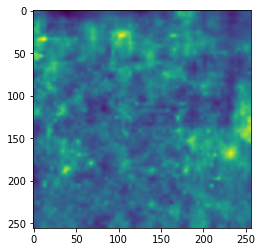

In [27]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

In [28]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(0.7798) tensor(True)


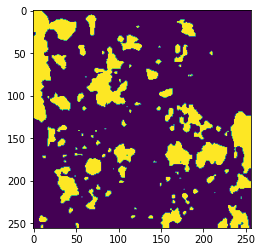

In [22]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

In [ ]:
image_filenames = list(Path("/content/drive/MyDrive/anomaly_detection/anomalib/results/images/04_abnormal").glob("**/*.jpg"))
for filename in image_filenames:
    image = Image.open(filename)
    display(image)

Output hidden; open in https://colab.research.google.com to view.

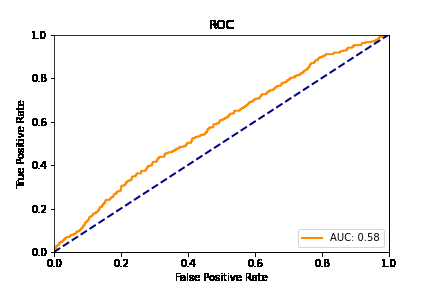

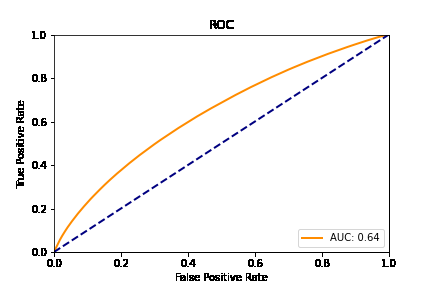

In [29]:
image_filenames = list(Path("/content/drive/MyDrive/anomaly_detection/anomalib/results/images").glob("**/*.png"))
for filename in image_filenames:
    image = Image.open(filename)
    display(image)